# Final Project 573

### Leila Gabrys

The goal of this project is to verify and compare observed vs forecasted data of tropical cyclones in the Atlantic and Eastern Pacific in the year 2014. It will read in a set of over 1000 emails with the forecasted data, as well as 30 BestTrack.dat files for the same storms' observed data. This python script is meant to be ran all at once, so as not to append anything to a list twice. Re-running a cell will not handle data correctly. My SSEC work is done in a text editor, but I have added the work to JupyterHub for ease. 

Email Files: courtesy of CIMSS Tropical Cyclone Group

To download the BestTrack data: [NHC Archive.](https://ftp.nhc.noaa.gov/atcf/archive/2014/)<br> To match with the email data, we need to download all of the 2014 emails with the data that start with <b><font color='#A020F0'>"bal" (for Atlantic Ocean) and "bep" (for eastern Pacific). 

To unzip these files, navigate to your directory and type in the terminal: <b><font color='#A020F0'>gunzip *.gz

In [1]:
#Import all packages possibly needed
import pandas as pd #Used in class
import numpy as np #Used in class
import csv
import os, time
import matplotlib.pylab as plt #Used in class
import itertools
import sys
#import pickle
from datetime import datetime #Did minitutorial
#import json
from itertools import groupby
from itertools import islice
from operator import itemgetter
import collections
from collections import Counter
import glob
from numpy import savetxt

__Reading in Emails__

In [2]:
array = pd.read_fwf('2014shearemails.txt', header=None) #Read in email file as pandas dataframe to turn it to list
array = array[0].tolist() #Make it into a list
listToStr = ' '.join([str(Subject) for Subject in array]) #Join emails into one enormous string
l = listToStr.split('Subject: ') #Split email string at each email starting with 'Subject: '
res = [i.strip("[]").split(", ") for i in l] #Make lists out of each email

In [3]:
# Make individual words strings in emails
string_emails0 = []
for email in res:
        for string_in in email:
                string_email = string_in.split(' ')
                while '' in string_email:
                        string_email.remove('')
        string_emails0.append(string_email)

In [4]:
print(string_emails0[0:2]) #Each item in the string_emails0 list represents an email separated by text values.
print(len(string_emails0)) #Length of number emails is printed: 1784

[[], ['TROPICAL', 'STORM', '03S', '0:00UTC', '12December2014', 'UW-CIMSS', 'Experimental', 'Vertical', 'Shear', 'TC', 'Intensity', 'Trend', 'Estimates', 'Current', 'Conditions', '(from', 'JTWC)', ':', 'Latitude', ':', '9:19:32', 'S', 'Longitude', ':', '93:18:55', 'E', 'Intensity', '(MSLP)', ':', '997.0', 'hPa', 'Max', 'Pot', 'Int', '(MPI)', ':', '917.4', 'hPa', 'MPI', 'differential', '(MSLP-MPI)', ':', '79.6', 'hPa', 'CIMSS', 'Vertical', 'Shear', 'Magnitude', ':', 'N/A', 'Direction', ':', 'N/A', 'TC', 'Intensity', 'Outlook', 'not', 'available', 'due', 'to', 'the', 'following', 'reasons', ':', '-', 'Environmental', 'shear', 'value', 'estimate', 'not', 'available', '-', 'Current', 'shear', 'charts', 'for', 'the', 'SOUTHWEST', 'PACIFIC', 'BASIN', 'can', 'be', 'found', 'at', ':', 'http://cimss.ssec.wisc.edu/tropic2/real-time/windmain.php?&basin=austwest&sat=wgms&prod=shr&zoom=&time=', '-', 'Additional', 'information', 'about', 'this', 'product', 'can', 'be', 'found', 'at', ':', 'http://cim

In [5]:
# Remove empty lists
string_emails = [ele for ele in string_emails0 if ele != []] #Any empty lists are now removed and we have defined a new variable string_emails

In [6]:
# Pull specific word from each email at index, append them to list
total = []
for eemail in string_emails:
        if "reasons" not in eemail: #The string 'reasons' appears in the emails that don't include data, so we will not include these emails
                if 'TYPHOON' not in eemail: #The string 'TYPHOON' appears in the emails not in the Atlantic or Pacific, so we will not include these emails
                        total.append(eemail)

In [7]:
print(total[0])
print(len(total)) #Removing the emails without data we need eliminated over 400 emails, we are now at len = 1343

['TROPICAL', 'STORM', '03S', '6:00UTC', '12December2014', 'UW-CIMSS', 'Experimental', 'Vertical', 'Shear', 'and', 'TC', 'Intensity', 'Trend', 'Estimates', 'Current', 'Conditions', '(from', 'JTWC)', ':', 'Latitude', ':', '9:39:32', 'S', 'Longitude', ':', '92:33:51', 'E', 'Intensity', '(MSLP)', ':', '994.0', 'hPa', 'Max', 'Pot', 'Int', '(MPI,from', 'Emanuel)', ':', '916.2', 'hPa', 'MPI', 'differential', '(MSLP-MPI)', ':', '77.8', 'hPa', 'CIMSS', 'Vertical', 'Shear', 'Magnitude', ':', '8.0', 'm/s', 'Direction', ':', '335.8', 'deg', 'Outlook', 'for', 'TC', 'Intensification', 'Based', 'on', 'Current', 'Env.', 'Shear', 'Values', 'and', 'MPI', 'Differential', 'Forecast', 'Interval', ':', '6hr', '12hr', '18hr', '24hr', 'F', 'F', 'F', 'F', 'Legend', ':', 'VF-Very', 'Favorable', 'F-Favorable', 'N-Neutral', 'U-Unfavorable', 'VU-Very', 'Unfavorable', '--', 'Mean', 'Intensity', 'Trend', '(negative', 'indicates', 'TC', 'deepening)', '--', '6hr', '12hr', '18hr', '24hr', 'VF', '<-3.0mb/', '6hr', '<-6.

The next cell is a function to grab data from giant email string. We will use indexing and the pattern of how the emails are written to find where our data is.  This requires looking at the strings of different emails to find commonality. There are unique values in the strings associated with the data we need, i.e. *'UW-CIMSS' always follows the name of the storm by 3 index values.*

In [8]:
def grab(long_string, email_word, word_index, word, desired_index, integer, desired_values):
        for alll in long_string: #Take a for loop over all the emails
                if word in alll: #If the word we are looking for is in this email...
                        email_word.append(alll) #...append word to a list
        for idx in range(len(email_word)):
                word_index.append(email_word[idx].index(word)) #Append the index of that word to a list
        for value_idx in word_index:
                desired_index.append(value_idx-integer) #Append the index of the desired value to the list using surrounding indexes
        for idx in range(len(email_word)):
                desired_values.append(email_word[idx][desired_index[idx]]) #Append desired value to list

In [9]:
# Grab storm names from each email
names_int = []
names_word = []
names_index = []
full_names = []
grab(total, names_int, names_word, 'UW-CIMSS', names_index, 3, full_names) # 'UW-CIMSS' always follows the name of the storm by 3 index values.

#Pull only atlantic and pacific storm names, given by E and L in string
names = []
for name in full_names: 
    if name[2:] == 'E':
        names.append(name)
    if name[2:] == 'L':
        names.append(name)
##For some reason this code up here was working, then it wasn't working so I tried the code below. That didn't turn out the way I wanted so I rewrote the code above 
##as is and it gave me what I needed. 

# countnames = {}
# names = []
# for name in full_names:
#         countnames[name] = countnames.get(name, 0) + 1 #Get number of times this storm has data in email string
#         if name[2:] == 'E':
#                 names.append(name*countnames[name])
#         if name[2:] == 'L':
#                 names.append(name*countnames[name]) 
# newnames = []
# names = list(set(names))
# for bigname in names:
#     newnames.append([bigname[i:i+3] for i in range(0, len(bigname), 3)])
# len(newnames)

This code above gave me the names that I needed, but shuffled their order which is crucial to aligning the data with the correct storms. Using 
the names for loop above gave me the names in the correct order I needed. 

In [10]:
# Remove emails that aren't in besttrack

#This for loop adds all the names so that there are one of each of them in the names_ordered list
names_ordered = []
for name0 in names:
        if name0 not in names_ordered:
                names_ordered.append(name0)
#This for loops the names in order, and grabs the emails that aren't repeated and matches them to the data in the BestTrack files we use later
final_t = []
for single in names_ordered:
        for email_e in total:
                if single in email_e:
                        final_t.append(email_e)

In [11]:
print(len(final_t))
print(final_t[0])

647
['<hawkins@nrlmry.navy.mi', 'TROPICAL', 'DEPRESSION', '01E', '0:00UTC', '23May2014', 'UW-CIMSS', 'Experimental', 'Vertical', 'Shear', 'and', 'TC', 'Intensity', 'Trend', 'Estimates', 'Current', 'Conditions', '(from', 'TPC)', ':', 'Latitude', ':', '10:23:45', 'N', 'Longitude', ':', '107:37:04', 'W', 'Intensity', '(MSLP)', ':', '1012.0', 'hPa', 'Max', 'Pot', 'Int', '(MPI,from', 'Emanuel)', ':', '894.2', 'hPa', 'MPI', 'differential', '(MSLP-MPI)', ':', '117.8', 'hPa', 'CIMSS', 'Vertical', 'Shear', 'Magnitude', ':', '4.1', 'm/s', 'Direction', ':', '189.7', 'deg', 'Outlook', 'for', 'TC', 'Intensification', 'Based', 'on', 'Current', 'Env.', 'Shear', 'Values', 'and', 'MPI', 'Differential', 'Forecast', 'Interval', ':', '6hr', '12hr', '18hr', '24hr', 'F', 'F', 'VF', 'VF', 'Legend', ':', 'VF-Very', 'Favorable', 'F-Favorable', 'N-Neutral', 'U-Unfavorable', 'VU-Very', 'Unfavorable', '--', 'Mean', 'Intensity', 'Trend', '(negative', 'indicates', 'TC', 'deepening)', '--', '6hr', '12hr', '18hr', '2

The length of our shortened email list is now 647 and we have all the emails we need to grab data from. This will use the same method above of grabbing the names for the winds, forecast intervals, and pressures.

*The cell below was a remake of the function above using a different email string, which turns out I didn't need since I could just make the email string a parameter.*

In [12]:
# # Grab everything needed from emails that match besttrack, using new final_t email string variable
# def grab1(email_word, word_index, word, desired_index, integer, desired_values):
#         for alll in final_t:
#                 if word in alll:
#                         email_word.append(alll)
#         for idx in range(len(email_word)):
#                 word_index.append(email_word[idx].index(word))
#         for value_idx in word_index:
#                 desired_index.append(value_idx-integer)
#         for idx in range(len(email_word)):
#                 desired_values.append(email_word[idx][desired_index[idx]])

In [13]:
# Grab windspeeds from each email
mag_index_list = []
mag_word_index = []
shear_index = []
shear_values0 = []
grab(final_t, mag_index_list, mag_word_index, "Direction", shear_index, 2, shear_values0) 
# 'Direction' always follows the shear windspeed of the storm by 2 index values.

In [14]:
# Convert m/s to knots, the data is originally in m/s
shear_values1 = [float(g) for g in shear_values0]
shear_values = [shear * 1.944 for shear in shear_values1]

In [15]:
# Grab hourly intervals from each email, and corresponding condition
int_index_list = []
int_word_index = []
hours_index = []
hour_values = []
intervals0 = []
grab(final_t, int_index_list, int_word_index, "Legend", hours_index, 4, hour_values)
# 'Legend' always follows the name of the storm by 4 index values.

In [16]:
# Grab interval values from each storm (there are 4 of them in each storm) 
for idx3 in range(len(hours_index)):
        for num in range(4):
                intervals0.append(int_index_list[idx3][hours_index[idx3]+num])

In [17]:
print(intervals0[0:20])

['F', 'F', 'VF', 'VF', 'F', 'F', 'VF', 'VF', 'F', 'VF', 'VF', 'VF', 'F', 'F', 'F', 'VF', 'F', 'F', 'F', 'F']


In [18]:
# Split separate intervals into lists
intervals = []
intervals1 = np.array_split(intervals0, len(hours_index)) #Create numpy array to split by the indexes of the hours in each email, to get 
                                                          #individual arrays of four forecast intervals
for intt in intervals1:
        intervals.append(intt.tolist()) #Make one big list of the intervals, each grouped into 4 for each storm's forecast

The function below grabs the average interval value. For tropical cyclone intensification, VF represents very favorable, F is favorable, N is neutral, U is unfavorable, and VU is very unfavorable. We can define the average values of the increase/decrease in storm intensity (pressure) and replace these letters with numeric values. 

In [19]:
def avg_interval(index, outlook, replacement):
        for ind in range(len(intervals)): #Get index of interval
                if intervals[ind][index] == outlook: #ind: index of interval, index: index of individual interval value (F, N, etc.)
                        intervals[ind][index] = intervals[ind][index].replace(outlook, replacement) #Replace letter with number
                        #print(intervals[ind][index])
                        intervals[ind][index] = float(intervals[ind][index]) #Turn value into float to include decimal

In [20]:
#Use function for average intervals of all the possible combinations
avg_interval(0, 'VF', '-3.0')
avg_interval(1, 'VF', '-6.0')
avg_interval(2, 'VF', '-9.0')
avg_interval(3, 'VF', '-12.0')

avg_interval(0, 'F', '-2.25')
avg_interval(1, 'F', '-4.5')
avg_interval(2, 'F', '-6.75')
avg_interval(3, 'F', '-9.0')

avg_interval(0, 'N', '0.0')
avg_interval(1, 'N', '0.0')
avg_interval(2, 'N', '0.0')
avg_interval(3, 'N', '0.0')

avg_interval(0, 'U', '2.25')
avg_interval(1, 'U', '4.5')
avg_interval(2, 'U', '6.75')
avg_interval(3, 'U', '9.0')

avg_interval(0, 'VU', '3.0')
avg_interval(1, 'VU', '6.0')
avg_interval(2, 'VU', '9.0')
avg_interval(3, 'VU', '12.0')

The printed intervals below show the comparison of the letter to number values

In [21]:
print(intervals1[0])
print(intervals[0])

['F' 'F' 'VF' 'VF']
[-2.25, -4.5, -9.0, -12.0]


In [22]:
#Grab storm dates from each storm
date_int = []
date_word = []
date_index = []
dates = []
grab(final_t, date_int, date_word, 'UW-CIMSS', date_index, 1, dates)
# 'UW-CIMSS' always follows the date of the storm by 1 index value.

In [23]:
#Grab storm times from each storm
time_int = []
time_word = []
time_index = []
times = []
grab(final_t, time_int, time_word, 'UW-CIMSS', time_index, 2, times)
# 'UW-CIMSS' always follows the time of the storm by 2 index values.

In [24]:
#Grab pressures from each storm
intensity_int = []
intensity_word = []
intensity_index = []
intensities = []
grab(final_t, intensity_int, intensity_word, "Max", intensity_index, 2, intensities)
# "Max" always follows the intensity (pressure) of the storm by 2 index values. 

In [25]:
#Turn dates into strings using datetime, do this to append times to string in the next cell
newdateform = []
for datex in dates:
        newdateform.append((datetime.strptime(datex, '%d%B%Y').strftime('%Y%m%d'))) 

In [26]:
#Add times in 'xx' order to the string of year, month and day
for idxidx in range(len(newdateform)): 
        if times[idxidx][:1] == '0':
                new_str0 = '0' + times[idxidx]
        if times[idxidx][:1] == '6':
                new_str6 = '0' + times[idxidx]
times = [new_str6 if s=='6:00UTC' else s for s in times]  #Add times in string
times = [new_str0 if t=='0:00UTC' else t for t in times]
for id in range(len(times)):
        newdateform[id]+=times[id][:2] #Add times in string

In [27]:
print(newdateform[0])

2014052300


The dates are now gathered, but are in string format. We can use them to now convert them to datetime objects.

In [28]:
#Append datetime dates to list
datetime_list = []
for cap in range(len(newdateform)):
        datetime_list.append(datetime(int(newdateform[cap][:4]), int(newdateform[cap][4:6]), int(newdateform[cap][6:8]), 
        int(newdateform[cap][8:10])))
#Successfully created new dataset with datetimes instead of string dates, but struggling to add them in to dictionary and have it output correctly

In [29]:
print(datetime_list[0])

2014-05-23 00:00:00


In [30]:
#Make dictionary with values by zipping them all together
emails = [{'Email Storm Name': names, 'Email Storm Date': datetime_list, 'Email Shear Magnitude': shear_values, 
                'Email Intensity': intensities, 'Email Interval': intervals} for names, datetime_list, shear_values, 
                 intensities, intervals in zip(names, datetime_list, shear_values, intensities, intervals)]

In [31]:
emails[0:5]

[{'Email Storm Name': '01E',
  'Email Storm Date': datetime.datetime(2014, 5, 23, 0, 0),
  'Email Shear Magnitude': 7.970399999999999,
  'Email Intensity': '1012.0',
  'Email Interval': [-2.25, -4.5, -9.0, -12.0]},
 {'Email Storm Name': '01E',
  'Email Storm Date': datetime.datetime(2014, 5, 23, 6, 0),
  'Email Shear Magnitude': 7.1928,
  'Email Intensity': '1012.0',
  'Email Interval': [-2.25, -4.5, -9.0, -12.0]},
 {'Email Storm Name': '01E',
  'Email Storm Date': datetime.datetime(2014, 5, 23, 12, 0),
  'Email Shear Magnitude': 6.4152,
  'Email Intensity': '1012.0',
  'Email Interval': [-2.25, -6.0, -9.0, -12.0]},
 {'Email Storm Name': '01E',
  'Email Storm Date': datetime.datetime(2014, 5, 23, 18, 0),
  'Email Shear Magnitude': 8.3592,
  'Email Intensity': '1009.0',
  'Email Interval': [-2.25, -4.5, -6.75, -12.0]},
 {'Email Storm Name': '01E',
  'Email Storm Date': datetime.datetime(2014, 5, 24, 0, 0),
  'Email Shear Magnitude': 9.914399999999999,
  'Email Intensity': '1005.0',
  'E

We now have each individual email data values in their own dictionary, which was also placed into a dataframe. We can now do the same thing and pull the same data from the BestTrack files.

#  

__Reading in BestTrack Files__

In [32]:
# Get the files and only years prior to 2014
file_location = ('/tornado/home1/class/fall21/lgabrys/AOS573/FinalProject/*.dat')
filenames = sorted(glob.glob(file_location)) #Grab paths and sort
file_location2 = ('*.dat')
filenames2 = sorted(glob.glob(file_location2)) #Use paths and sort to just the name of the file

In [33]:
print(filenames[0])
print(filenames2[0])

/tornado/home1/class/fall21/lgabrys/AOS573/FinalProject/bal012014.dat
bal012014.dat


In [34]:
# Get the datetimes, windspeeds, stormnames
datetimes0 = []
windspeed0 = []
pressure0 = []
def open_file(list_to, int_a):
        for file2 in filenames2: #Get individual filename in filenames
                with open(file2) as f: #Read each file
                        list_to.append([line.split()[int_a] for line in f]) #Append specific values to list where they appear in the read file
open_file(datetimes0, 2) #Dates appear at index 2
open_file(windspeed0, 8) #Windspeeds appear at index 8
open_file(pressure0, 9) #Pressures appear at index 9
print(datetimes0[0][0])
print(windspeed0[0][0])
print(pressure0[0][0])
#All of these values have commas so they cannot be turned into integers

2014062818,
20,
1017,


In [35]:
# Remove commas from datetimes and windspeeds
datetimes = []
windspeed = []
pressure = []
def remove_comma(list_change, list_add):
        for list_a in list_change: #Read in list of data we gathered with values w/ commas
                fulllist = []
                for comma0 in list_a: #Grab each individual value from each group
                        comma = comma0.replace(',', '') #Replace the comma in each string with nothing
                        fulllist.append(comma) #Append these values without commas to own individual list
                list_add.append(fulllist) #Append these lists to one big list of data
remove_comma(datetimes0, datetimes) 
remove_comma(windspeed0, windspeed)
remove_comma(pressure0, pressure)
print(datetimes[0][0])
print(windspeed[0][0])
print(pressure[0][0])

2014062818
20
1017


In [36]:
#Get names of storms from file names
stormnames0 = []
for file in filenames2: #Get names of storms
        if int(file[-8:-4]) == 2014: #If the storm name ends in 2014 grab the storm name
                stormnames0.append(file[-12:-4])
stormnames0[0:5]

['al012014', 'al022014', 'al032014', 'al042014', 'al052014']

*Note: the above cell was run in the event that more BestTrack files are in the directory from different years other than 2014. Because I only have the 2014 data files in Jupyter (not the case in the SSEC spinner directory), this code is not necessary, but still a nice check.*

In [37]:
#Make stormnames the same as emails
stormnames = []
for storm_name in stormnames0: #individual storm name in list of names
        if storm_name[:2] == 'ep': #if storm is from the eastern Pacific
                storm_name1 = storm_name[2:4] + ('E') #add E for eastern Pacific to storm name string
        elif storm_name[:2] == 'al': #if storm is from the Atlantic
                storm_name1 = storm_name[2:4] + ('L') #add L for Atlantic to storm name string
        stormnames.append(storm_name1) #Append all these names to the stormnames list

In [38]:
# Convert windspeed to integers using for loop and indexing
for integer in windspeed:
        for i in range(0, len(integer)):
                integer[i] = int(integer[i])

In [39]:
# Convert datetimes to day of year
date_wind = []
years = []
months = []
days = []
hours1 = []
hours2 = []
for idx in range(len(datetimes)): #For loop for indexing through datetime lists grabbed earlier (still in string format)
        #dwdict = {}
        for idx2 in range(len(datetimes[idx])): #For loop indexing through individual string datetimes
                #dwdict[datetimes[idx][idx2]] = windspeed[idx][idx2]
                year = int(datetimes[idx][idx2][:4]) #Grab each year
                years.append(year) #Append year to year list
                month = int(datetimes[idx][idx2][4:6]) #Grab each month
                months.append(month) #Append month to month list
                day = int(datetimes[idx][idx2][6:8]) #Grab each day
                days.append(day) #Append day to day list
                hour1 = int(datetimes[idx][idx2][8:9]) #Grab first digit of hour
                hours1.append(hour1) #Append first digit of hour to hour1 list
                hour2 = int(datetimes[idx][idx2][9:]) #Grab second digit of hour
                hours2.append(hour2) #Append second digit of hour to hour2 list
        #date_wind.append(dwdict)
print(years[0], months[0], days[0], hours1[0], hours2[0])

2014 6 28 1 8


In [40]:
import datetime
days_of_year = []
for w in range(len(years)):
        dates = str(datetime.datetime(years[w], months[w], days[w],  hours1[w], hours2[w]).strftime('%j')) 
        days_of_year.append(dates) #Get the days of year that these storms take place by converting to datetime and append them to list
full_datetimes = [j for e in datetimes for j in e] #Separate dates into each indicidual date
print(datetimes[0])
print(full_datetimes[0])
print(days_of_year[0]) #The days of year will help us with datetime conversion later

['2014062818', '2014062900', '2014062906', '2014062912', '2014062918', '2014063000', '2014063006', '2014063012', '2014063018', '2014070100', '2014070106', '2014070112', '2014070118', '2014070200', '2014070206', '2014070206', '2014070212', '2014070212', '2014070218', '2014070218', '2014070300', '2014070300', '2014070300', '2014070306', '2014070306', '2014070306', '2014070312', '2014070312', '2014070312', '2014070318', '2014070318', '2014070318', '2014070400', '2014070400', '2014070400', '2014070403', '2014070403', '2014070403', '2014070406', '2014070406', '2014070406', '2014070408', '2014070408', '2014070408', '2014070412', '2014070412', '2014070412', '2014070418', '2014070418', '2014070418', '2014070500', '2014070500', '2014070500', '2014070506', '2014070506', '2014070512', '2014070512', '2014070518', '2014070518', '2014070600', '2014070600', '2014070606', '2014070612', '2014070618', '2014070700', '2014070706', '2014070712', '2014070718', '2014070800', '2014070806', '2014070812', '2014

In [41]:
#Make new string of years with decimals as times
year_string = []
for new_idx in range(len(days_of_year)): #Index through days of year and add the hours as decimals 
        if full_datetimes[new_idx][8:] == '00':
                days_of_year[new_idx] += '.00' 
        if full_datetimes[new_idx][8:] == '06':
                days_of_year[new_idx] += '.25'
        if full_datetimes[new_idx][8:] == '12':
                days_of_year[new_idx] += '.50'
        if full_datetimes[new_idx][8:] == '18':
                days_of_year[new_idx] += '.75'
        year_string.append(full_datetimes[new_idx][:4])
        year_string[new_idx] += days_of_year[new_idx]

In [42]:
print(year_string[0:5]) # This is the day of the year with the hour in decimal format, as a string

['2014179.75', '2014180.00', '2014180.25', '2014180.50', '2014180.75']


In [43]:
# Create date in different format using datetime
from datetime import datetime
full_date = []
for date_x in year_string:
        xxx = datetime.strptime(date_x[:7], '%Y%j').strftime('%d%B%Y') #Converting the days of year to datetimes
        full_date.append(xxx) #Appending new datetimes to a list

In [44]:
# Break up new lists to fit in dictionary

#Get lengths of datetime lists
d_list = []
for little in datetimes:
        d_list.append(len(little))

In [45]:
print(d_list) #This is the individual length of the datetime lists, or number of dates from each storm. We will use this across all of the 
#data lists to separate them by storm. 

[76, 17, 58, 85, 13, 88, 27, 102, 37, 65, 14, 70, 42, 11, 13, 126, 30, 102, 133, 95, 60, 86, 66, 72, 25, 59, 56, 56, 11, 47]


In [46]:
#Split dates into lengths of list. This code below effectively splits a list into the lengths given by the list of lengths (in this case, d_list)
full_date_input = iter(full_date) 
full_date_output = [list(islice(full_date_input, elem)) for elem in d_list]
print(full_date_output[0])

['28June2014', '29June2014', '29June2014', '29June2014', '29June2014', '30June2014', '30June2014', '30June2014', '30June2014', '01July2014', '01July2014', '01July2014', '01July2014', '02July2014', '02July2014', '02July2014', '02July2014', '02July2014', '02July2014', '02July2014', '03July2014', '03July2014', '03July2014', '03July2014', '03July2014', '03July2014', '03July2014', '03July2014', '03July2014', '03July2014', '03July2014', '03July2014', '04July2014', '04July2014', '04July2014', '04July2014', '04July2014', '04July2014', '04July2014', '04July2014', '04July2014', '04July2014', '04July2014', '04July2014', '04July2014', '04July2014', '04July2014', '04July2014', '04July2014', '04July2014', '05July2014', '05July2014', '05July2014', '05July2014', '05July2014', '05July2014', '05July2014', '05July2014', '05July2014', '06July2014', '06July2014', '06July2014', '06July2014', '06July2014', '07July2014', '07July2014', '07July2014', '07July2014', '08July2014', '08July2014', '08July2014', '08Ju

In [47]:
#Convert dates to datetimes type
datetime_list = []
for a in range(len(datetimes)): #Get lists of datetimes
        for b in range(len(datetimes[a])): #Get dates from lists of datetimes
                datetime_list.append(datetime(int(datetimes[a][b][:4]), int(datetimes[a][b][4:6]), 
                int(datetimes[a][b][6:8]), int(datetimes[a][b][8:10]))) #Turn all the datetime strings into datetime objects
print(datetime_list[0:5])
type(datetime_list[0])

[datetime.datetime(2014, 6, 28, 18, 0), datetime.datetime(2014, 6, 29, 0, 0), datetime.datetime(2014, 6, 29, 6, 0), datetime.datetime(2014, 6, 29, 12, 0), datetime.datetime(2014, 6, 29, 18, 0)]


datetime.datetime

In [48]:
#Separate lists by lengths of all lists, as we did above using list comprehension
length = iter(datetime_list)
stormdates = [list(islice(length, elem0)) for elem0 in d_list]

In [49]:
# Create dictionary with stormname, date, and windspeed

tc_int = [{'BestTrack Storm Name': stormnames, 'BestTrack Storm Date': stormdates, 'BestTrack Shear Magnitude': windspeed, 
           'BestTrack Intensity': pressure, 'BestTrack Full_Date': full_date_output} for stormnames,stormdates,windspeed,pressure,
          full_date_output in zip(stormnames,stormdates,windspeed,pressure,full_date_output)]
tc_int0 = pd.DataFrame(tc_int)
tc_int0.head()

BestTrack Storm Name                               BestTrack Storm Date  \
0                  01L  [2014-06-28 18:00:00, 2014-06-29 00:00:00, 201...   
1                  02L  [2014-07-19 12:00:00, 2014-07-19 18:00:00, 201...   
2                  03L  [2014-07-29 06:00:00, 2014-07-29 12:00:00, 201...   
3                  04L  [2014-08-23 18:00:00, 2014-08-24 00:00:00, 201...   
4                  05L  [2014-09-01 12:00:00, 2014-09-01 18:00:00, 201...   

                           BestTrack Shear Magnitude  \
0  [20, 20, 20, 20, 25, 25, 25, 25, 30, 30, 30, 3...   
1  [20, 20, 20, 20, 20, 20, 25, 25, 30, 30, 30, 3...   
2  [25, 30, 30, 30, 30, 30, 30, 35, 35, 40, 40, 4...   
3  [30, 30, 35, 40, 45, 45, 45, 50, 50, 50, 50, 6...   
4  [25, 30, 35, 40, 45, 40, 40, 40, 40, 35, 25, 2...   

                                 BestTrack Intensity  \
0  [1017, 1017, 1017, 1016, 1015, 1014, 1013, 101...   
1  [1012, 1012, 1012, 1012, 1012, 1012, 1012, 101...   
2  [1013, 1012, 1012, 1012, 1012, 1012, 1011, 101...   
3  [1005, 1004, 1002, 1001, 1001, 998, 996, 993, ...   
4  [1009, 1009, 1007, 1005, 1005, 1003, 1001, 100...   

                                 BestTrack Full_Date  
0  [28June2014, 29June2014, 29June2014, 29June201...  
1  [19July2014, 19July2014, 20July2014, 20July201...  
2  [29July2014, 29July2014, 29July2014, 30July201...  
3  [23August2014, 24August2014, 24August2014, 24A...  
4  [01September2014, 01September2014, 02September...

This dataframe for the BestTrack data is similar to that of the emails, however, the storm names are given only once and do not repeat for the number of values in a storm's dataset. Ideally, we would use the dataframes if they were in the exact same format, but since they're not, we can continue using the dictionaries and reference the dataframe for visualization of how the data is organized.

__Using the emails and BestTrack files together__

In [50]:
#Organizing values I grabbed from the emails
separated = []
stormname_list0 = []
pressures0 = []
dates0 = []
for list1 in emails: #Read into emails list of dictionaries
        for v in list1.items(): #Get dictionary items
                list1['Email Intensity'] = float(list1['Email Intensity']) #Convert the pressures to floats from strings
        stormname_list0.append(list1['Email Storm Name']) # Get a list of the stormnames from these items
        pressures0.append(list1['Email Intensity']) #Get a list of the pressures from these items
        dates0.append(list1['Email Storm Date']) #Get a list of the dates from these items
        separated.append(list1) #Append each dictionary again to an individual list
print(stormname_list0[0:10])
print(pressures0[0:10])
print(dates0[0:10])
print(separated[0])

['01E', '01E', '01E', '01E', '01E', '01E', '01E', '01E', '01E', '01E']
[1012.0, 1012.0, 1012.0, 1009.0, 1005.0, 1000.0, 997.0, 987.0, 983.7, 973.5]
[datetime.datetime(2014, 5, 23, 0, 0), datetime.datetime(2014, 5, 23, 6, 0), datetime.datetime(2014, 5, 23, 12, 0), datetime.datetime(2014, 5, 23, 18, 0), datetime.datetime(2014, 5, 24, 0, 0), datetime.datetime(2014, 5, 24, 6, 0), datetime.datetime(2014, 5, 24, 12, 0), datetime.datetime(2014, 5, 24, 18, 0), datetime.datetime(2014, 5, 25, 0, 0), datetime.datetime(2014, 5, 25, 6, 0)]
{'Email Storm Name': '01E', 'Email Storm Date': datetime.datetime(2014, 5, 23, 0, 0), 'Email Shear Magnitude': 7.970399999999999, 'Email Intensity': 1012.0, 'Email Interval': [-2.25, -4.5, -9.0, -12.0]}


In [51]:
#Zip dictionary items together to lists instead of a dictionary
valuelist = []
for seperate_email in separated:
        keys, values = (zip(*seperate_email.items()))
        valuelist.append(list(values))
print(valuelist[0])

['01E', datetime.datetime(2014, 5, 23, 0, 0), 7.970399999999999, 1012.0, [-2.25, -4.5, -9.0, -12.0]]


In [52]:
#Remove name of storm for ease
for val in valuelist:
        del val[0]
print(valuelist[0])

[datetime.datetime(2014, 5, 23, 0, 0), 7.970399999999999, 1012.0, [-2.25, -4.5, -9.0, -12.0]]


In [53]:
final_stormname = list(dict.fromkeys(stormname_list0)) #Get full list of thirty storm names
count_name = collections.Counter(stormname_list0) #Count how many of each name there are
valcount = []
for val1 in count_name.values():
        valcount.append(val1) 
print(valcount) #Number of each value there are

[30, 6, 24, 21, 7, 7, 46, 11, 37, 47, 55, 20, 21, 24, 26, 14, 26, 26, 26, 3, 25, 15, 8, 21, 21, 4, 34, 13, 25, 4]


In [54]:
value_input = iter(valuelist)
value_output = [list(islice(value_input, elem)) for elem in valcount] #Split value list into lenghts of values
email_values = dict(zip(final_stormname, value_output)) #Dictionary of email values that will match dictionary of BestTrack email values
email_values['01E'][0]

[datetime.datetime(2014, 5, 23, 0, 0),
 7.970399999999999,
 1012.0,
 [-2.25, -4.5, -9.0, -12.0]]

We now have a list of email_values dictionaries for each storm, with the key as the name of the storm and the data as the values.

In [55]:
#Organizing values I grabbed from BestTrack
seplist = []
besttrack_names = []
group_values = []
for list2 in tc_int:
        besttrack_names.append(list2['BestTrack Storm Name']) #Names of storms
        del[list2['BestTrack Storm Name']] #Deleting values not wanted
        del[list2['BestTrack Full_Date']]
        group_values.append(list(list2.values())) #Dates, windspeeds, pressures combined into one list per storm
        seplist.append(list2['BestTrack Storm Date']) #Adding individual lists of data to a separate list
for list3 in tc_int:
        seplist.append(list3['BestTrack Shear Magnitude'])
for list4 in tc_int:
        seplist.append(list4['BestTrack Intensity']) 

In [56]:
comb_list = []
for xx in seplist:
        comb_list.extend(xx) #Combining all of the lists into one huge list with all of the data, organized by dates, pressures, and windspeeds.
#We will use this to separate the lists individually by their preferred type. I've printed below just how massive this set is, and it is organized
#equally by the types of data we need. 

In [57]:
print(comb_list[0])
print(comb_list[1742])
print(comb_list[3400])

2014-06-28 18:00:00
20
115


In [58]:
big = []
threelist = [comb_list[i:i+int(len(comb_list)/3)] for i in range(0, len(comb_list), int(len(comb_list)/3))] 
#Separating combined list into three lists full of dates, windspeeds, and pressures
for r in range(len(threelist)):
        for y in range(len(threelist[r])):
                big.append([threelist[0][y], threelist[1][y], threelist[2][y]])
#Appending an individual list in the format of datetime, windspeed, and pressure

In [59]:
length_list = []
for len1 in group_values:
        length_list.append(len(len1[0])) #Getting lengths of each storm value data set group

In [60]:
print(length_list)

[76, 17, 58, 85, 13, 88, 27, 102, 37, 65, 14, 70, 42, 11, 13, 126, 30, 102, 133, 95, 60, 86, 66, 72, 25, 59, 56, 56, 11, 47]


In [61]:
value_input0 = iter(big)
value_output0 = [list(islice(value_input0, elem0)) for elem0 in length_list] #Splitting the besttrack values again into each storm
besttrack_values = dict(zip(besttrack_names, value_output0)) #Making dictionary to call storms by name to get data
besttrack_values['01E'][0]

[datetime.datetime(2014, 5, 22, 6, 0), 25, '1007']

Now that we have the data organized as we need it, we can actually plot it. The function below will plot all of the storm data and has the option to save the plots as .pngs (commented out). It works by importing just one name into the parameter, which will plot one storm's data. You can also use a for loop through a list of names and it will output plots of all 30 storms at once. 

In [62]:
print(stormnames) #Here's the list of available stormnames to plot

['01L', '02L', '03L', '04L', '05L', '06L', '07L', '08L', '09L', '01E', '02E', '03E', '04E', '05E', '06E', '07E', '08E', '09E', '10E', '11E', '12E', '13E', '14E', '15E', '16E', '17E', '18E', '19E', '20E', '21E']


In [63]:
def graph_data(name):
        best_dates = []
        BTwind = []
        BTpressure = []
        bestfull = besttrack_values[name]
        for dl in bestfull:
                best_dates.append(dl[0]) #Get dates from besttrack_values
                BTwind.append(float(dl[1])) #Get wind speeds from besttrack_values
                BTpressure.append(float(dl[2])) #Get pressures from besttrack_values
        email_dates = []
        Ewind = []
        Epressure = []
        emailfull = email_values[name]
        for el in emailfull:
                email_dates.append(el[0]) #Get dates from email_values
                Ewind.append(float(el[1])) #Get shear wind speeds from email_values
                Epressure.append(float(el[2])) #Get pressures from email_values
        fig, ax = plt.subplots(figsize = (12, 8))
        ax.plot(best_dates, BTpressure, label = 'BestTrack Pressure', color = '0', marker = '.') #plot pressures from besttrack over date
        ax.plot(email_dates, Epressure, label = 'Email Pressure', color = '0.5', marker = '.') #plot pressures from email over date
        ax.set_title('Pressure and Wind Speeds over Time for Storm '+ name, fontsize = 15) #set title with name of storm
        ax.set_xlabel('Dates', fontsize = 10) #set xlabel for dates
        ax.set_ylabel('Pressure (mb)', fontsize = 10) #set ylabel for pressures
        ax.legend(loc = 'lower right', prop = {'size': 12}) #set legend for both pressure values
        ax.tick_params(axis = 'y', labelsize = 10) #set tick parameters
        ax2 = ax.twinx() #create twin axis to also plot windspeeds
        ax2.plot(best_dates, BTwind, label = 'Top Wind Speed (BestTrack)', color = 'm') #plot winds from besttrack over date
        ax2.plot(email_dates, Ewind, label='Wind Shear (Email)') #plot wind shear from emails over date
        ax2.set_xlabel('Dates', fontsize = 10) #set same xlabel for dates on twin axis
        #ax2.tick_params(axis = 'x')  #set tick parameters
        ax2.set_ylabel('Wind Speed (kts)', fontsize = 10) #set other ylabel for winds
        ax2.tick_params(axis = 'x', labelsize = 10) #set tick parametres
        ax2.tick_params(axis = 'y', labelsize = 10) 
        ax2.legend(loc = 'upper right', prop = {'size': 12}) #set legend for both wind values
        plt.subplots_adjust(hspace = 0.3)
        #plt.savefig(name)
        plt.show()

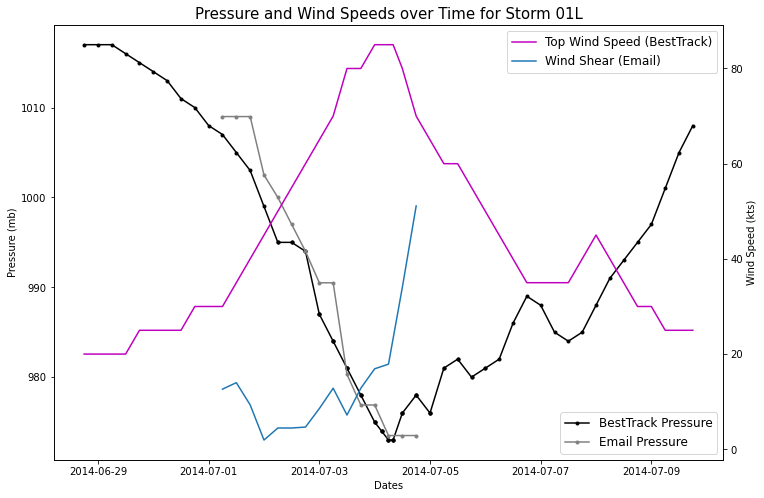

In [64]:
graph_data(stormnames[0]) #Grabbing storm data graph by index

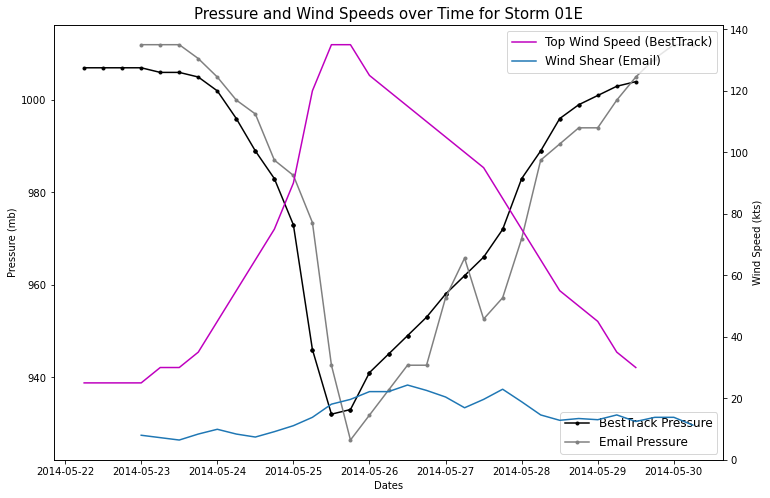

In [65]:
graph_data('01E') #Grabbing storm data graph by storm name

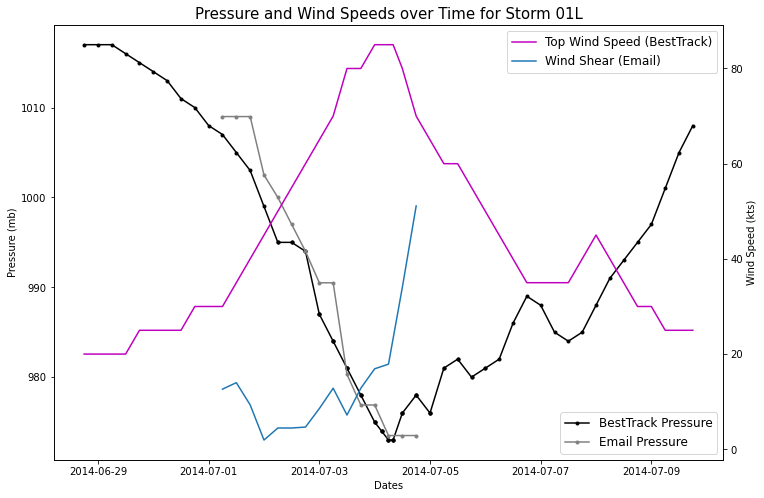

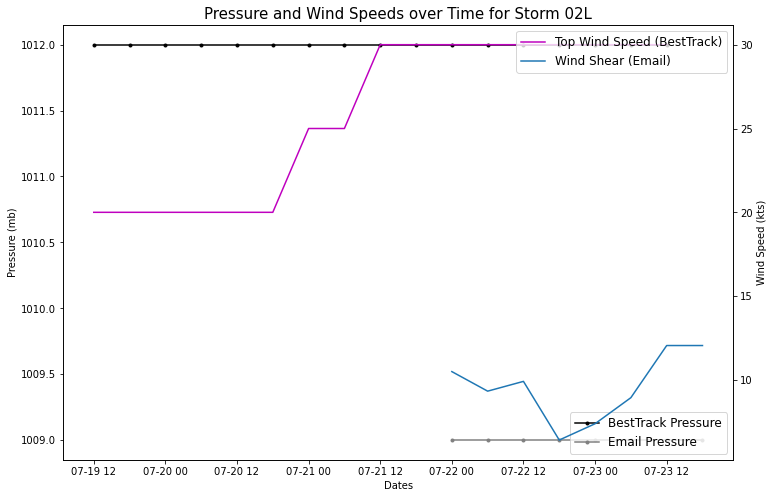

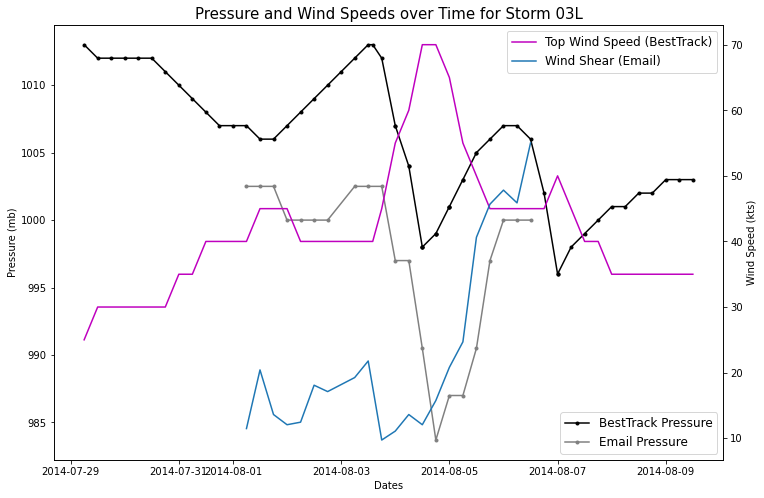

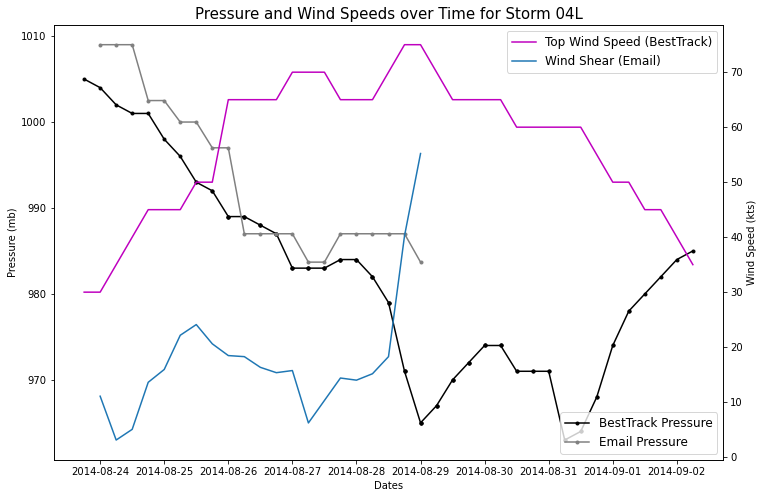

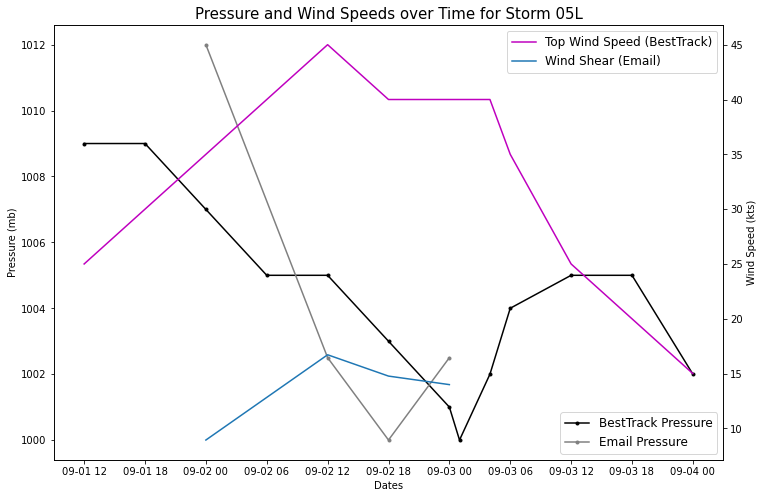

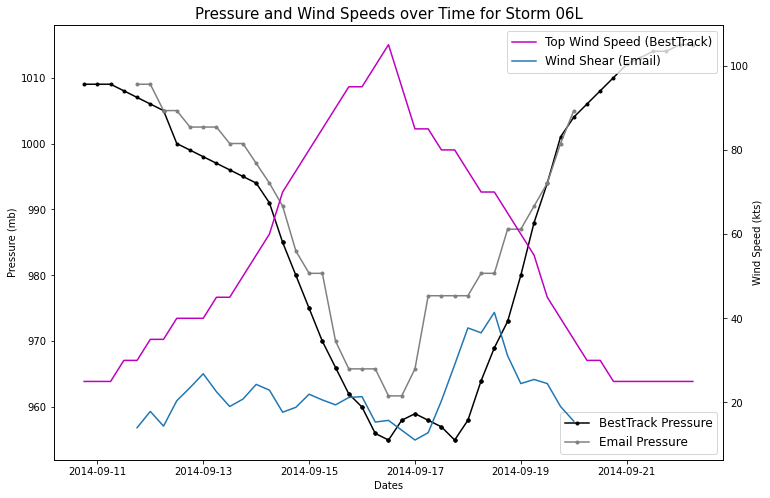

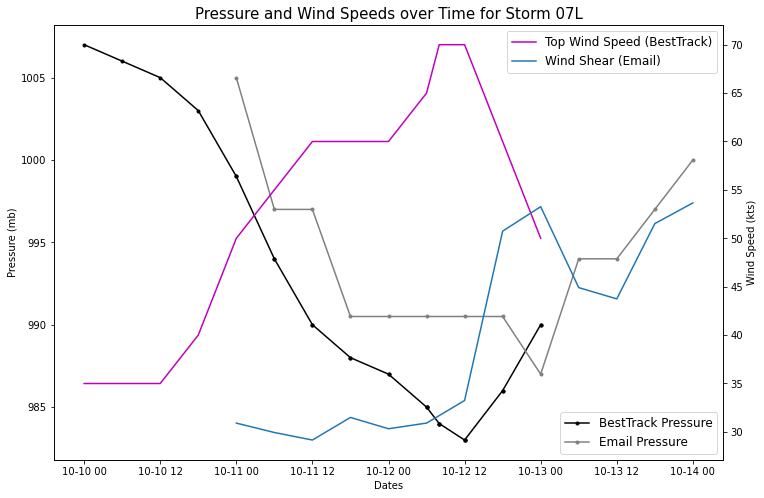

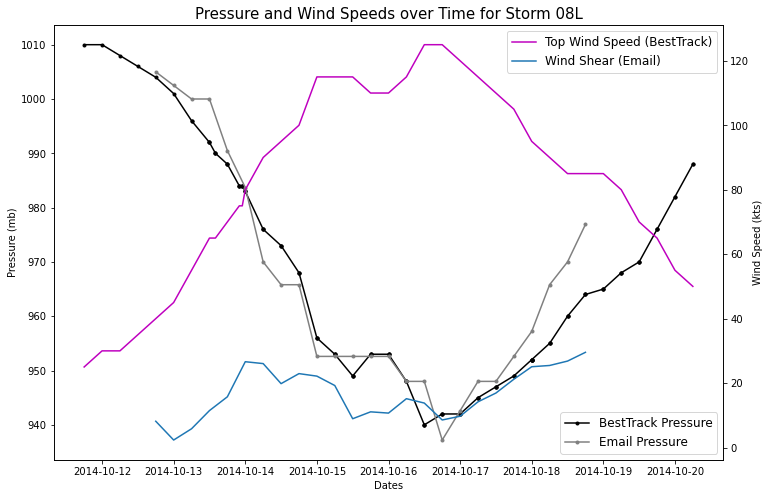

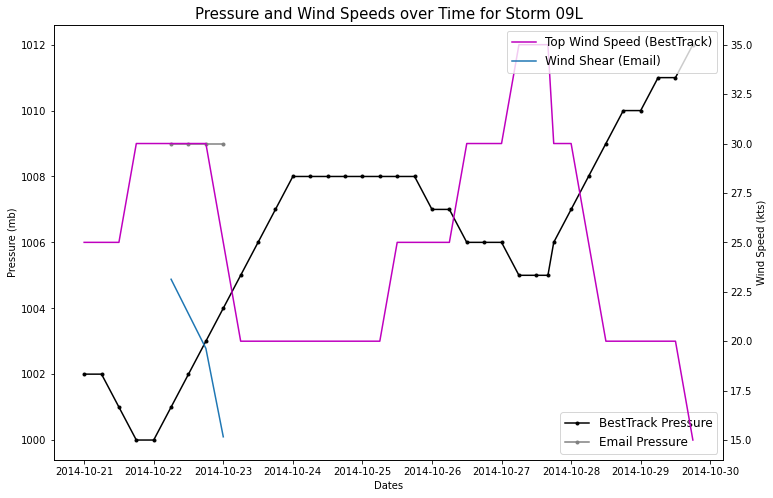

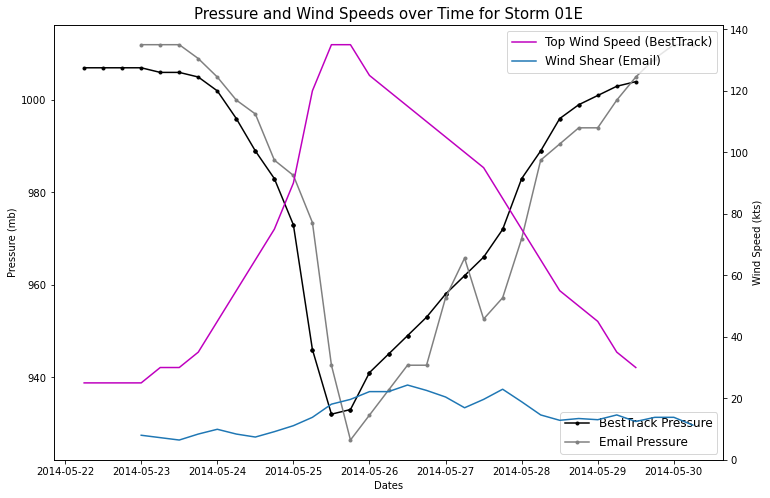

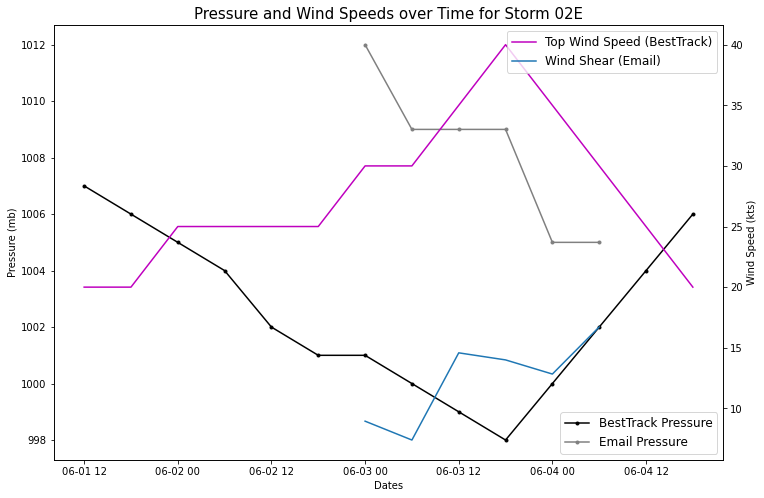

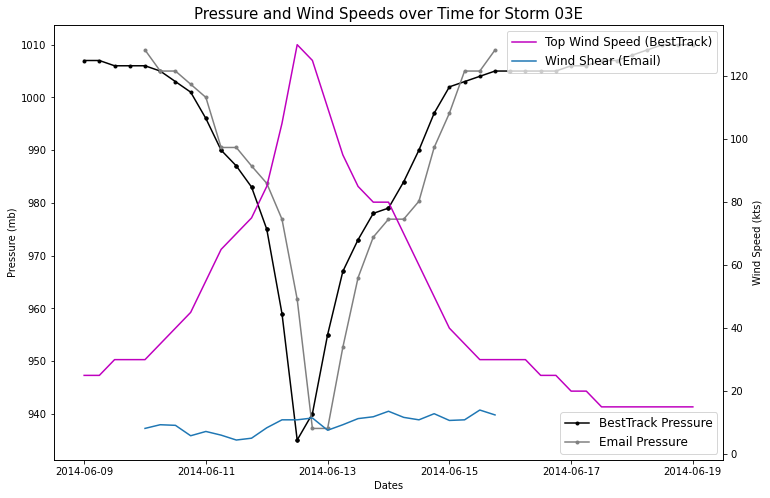

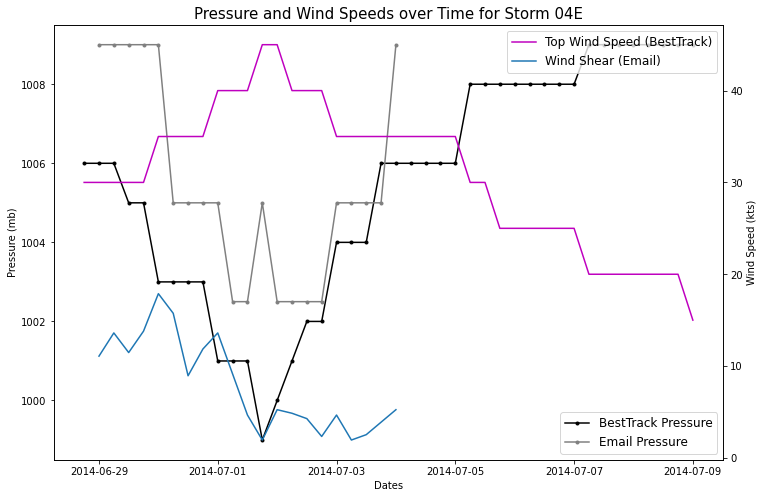

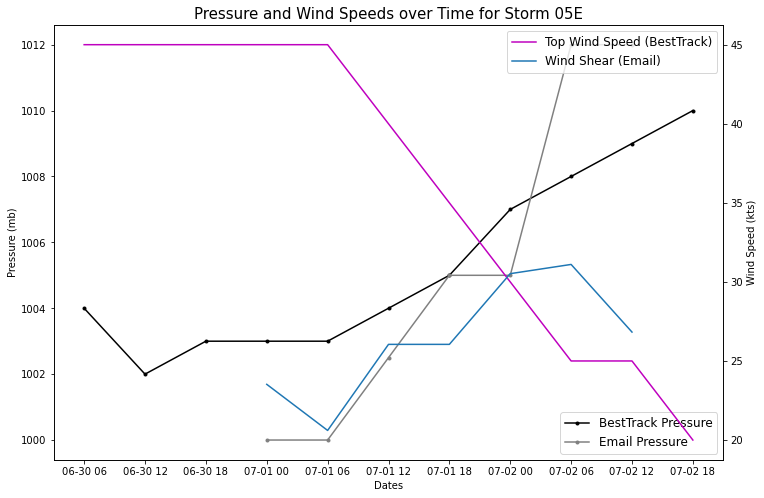

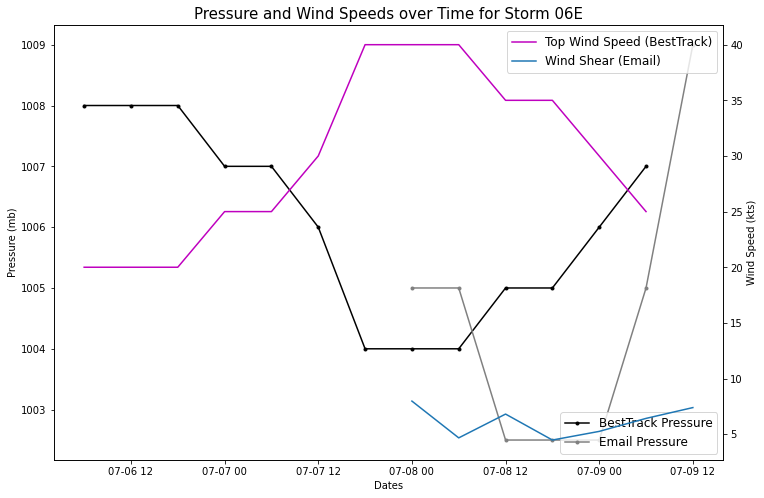

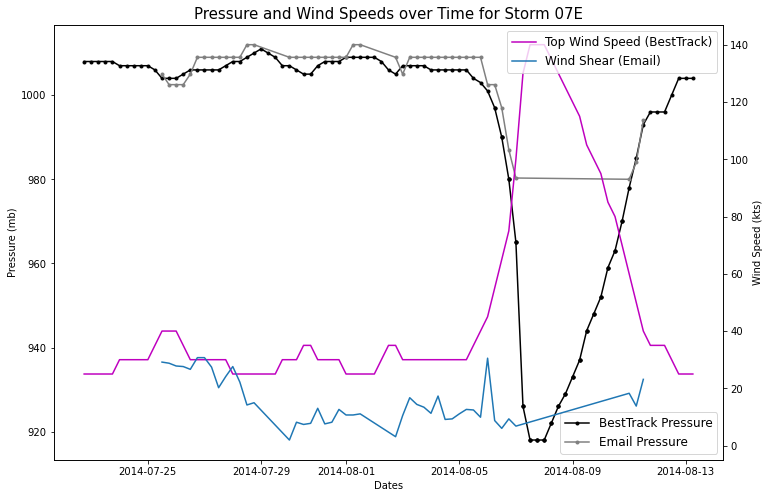

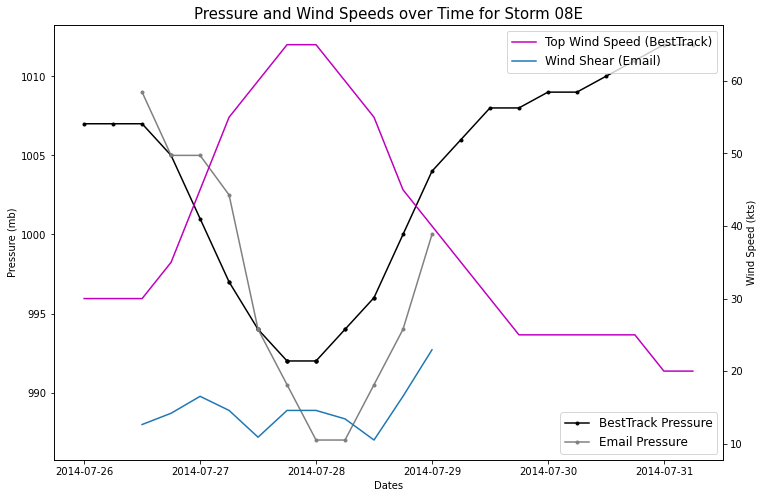

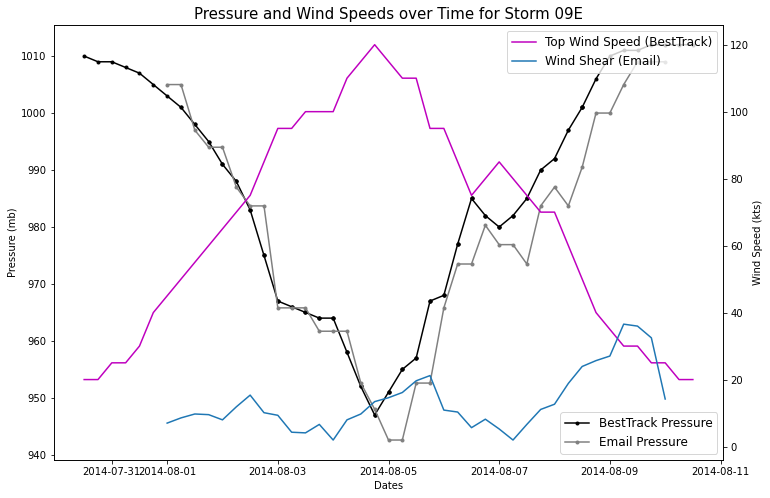

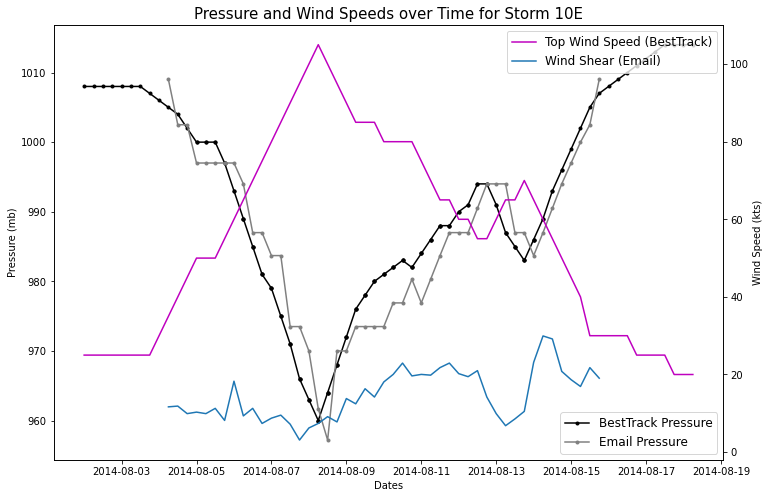

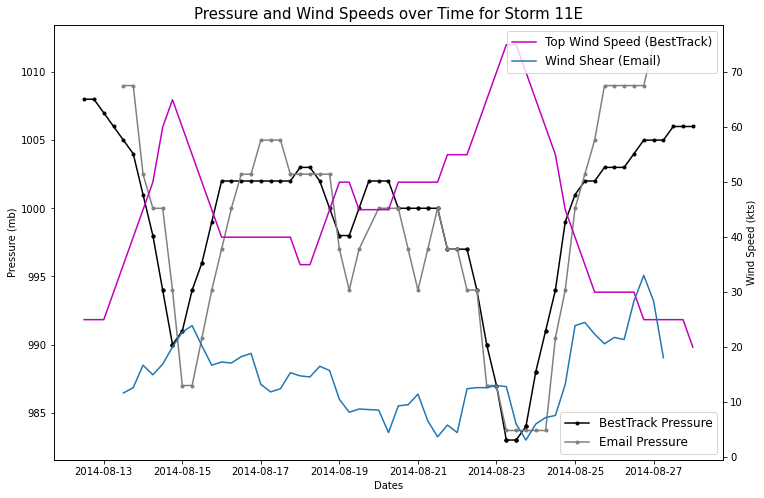

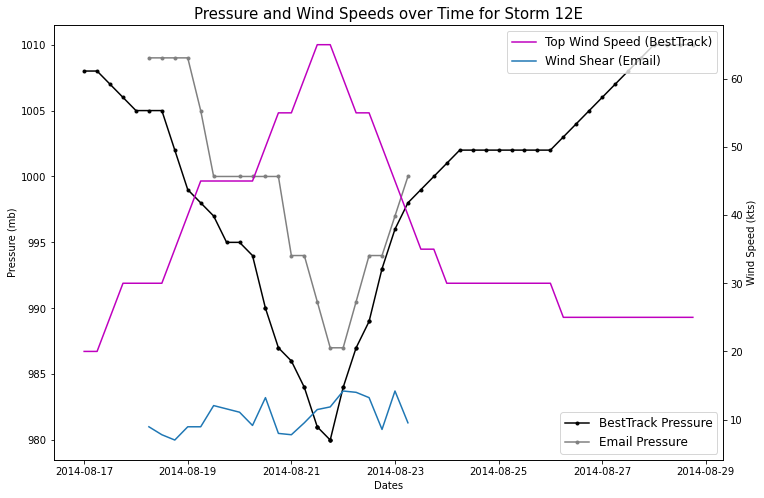

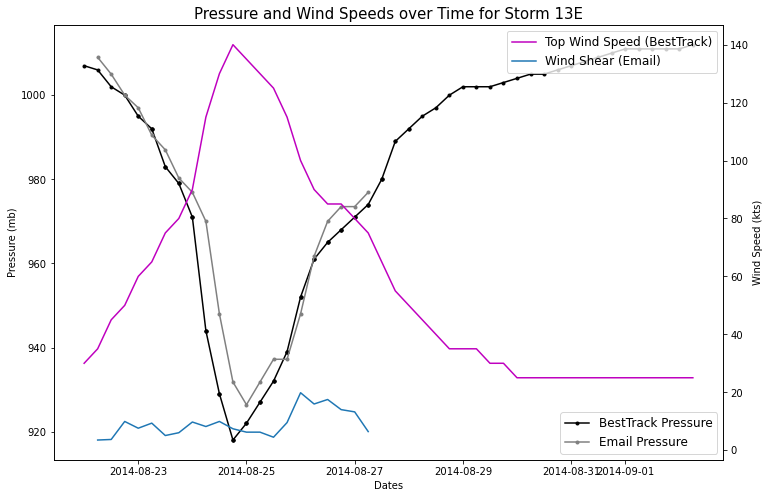

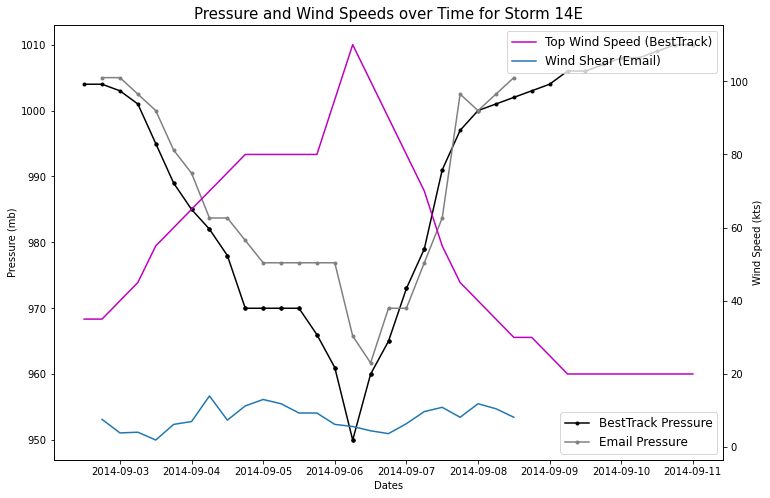

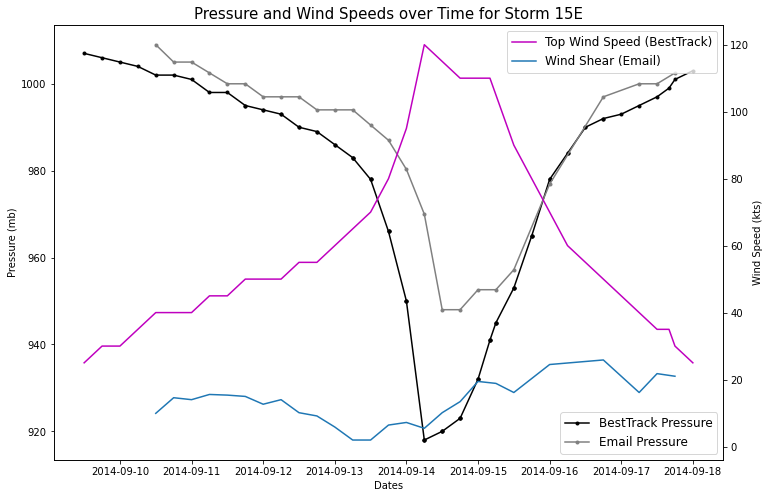

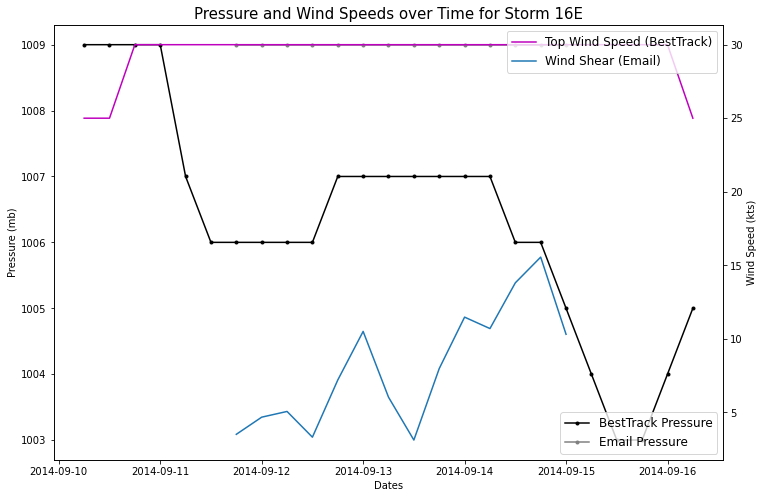

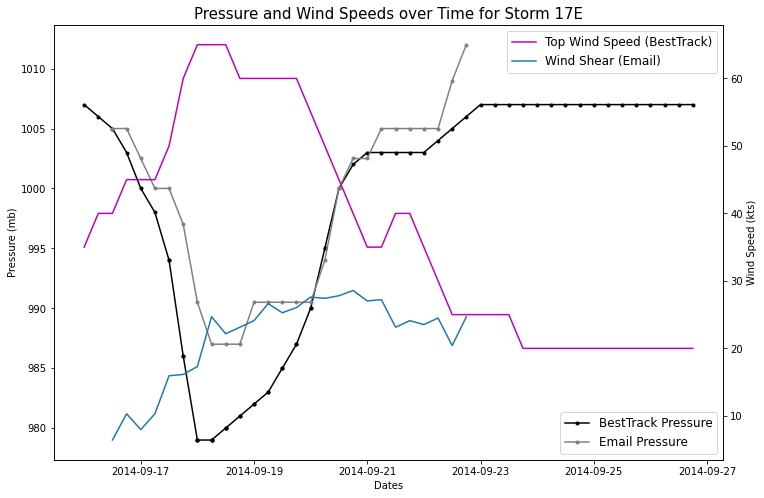

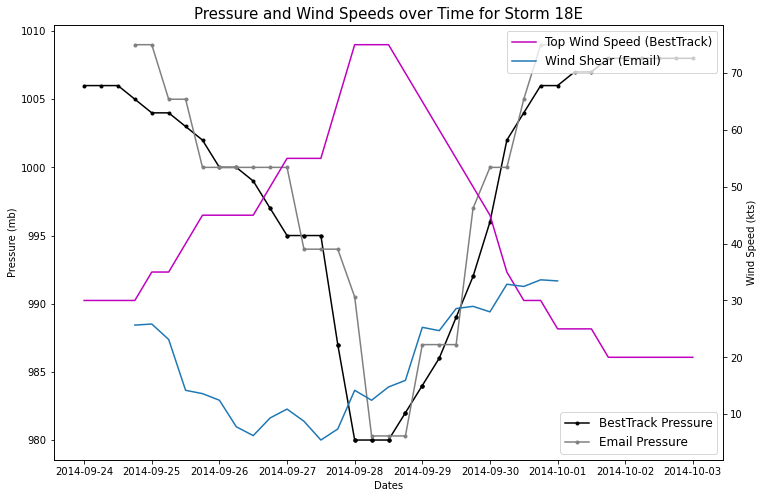

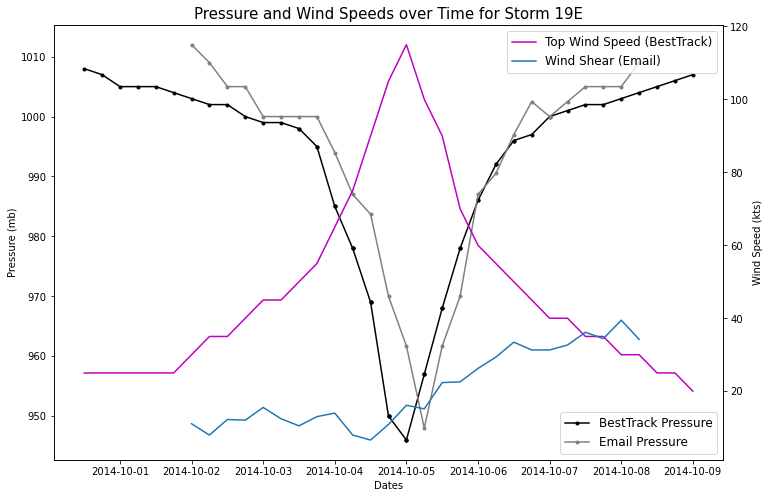

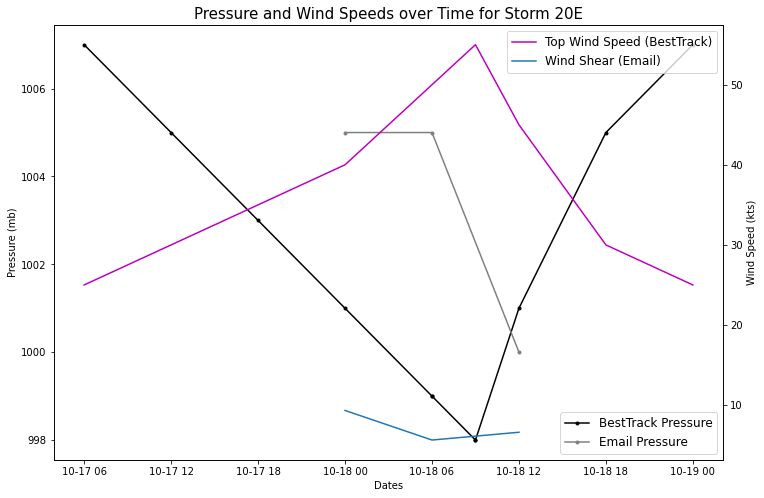

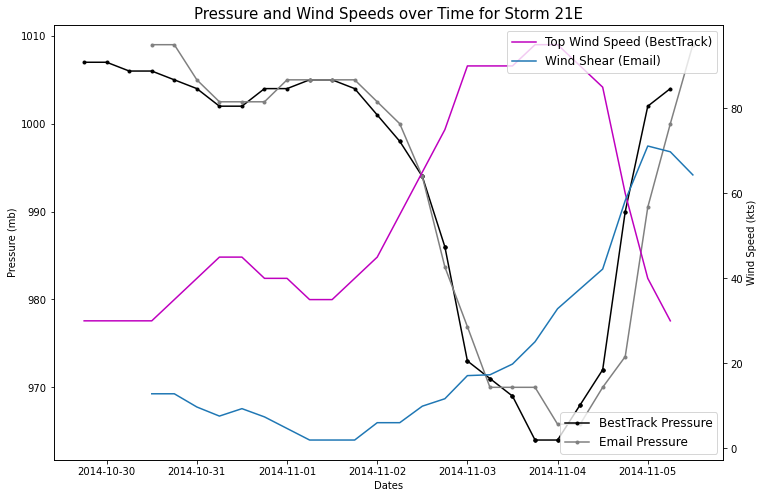

In [66]:
for names in stormnames:
    graph_data(names) #Grabbing all of the storm data graphs using all 30 storms

__Next Steps__

This was the farthest extension on my research project that was successful (these graphs). Most of the data from the emails did line up with the observed data from the BestTrack files. The graphs did show that there were some limitations to both of the datasets. Some storms had fewer durations of storm data taken, and so the graphs look wonky and incomplete (seen in storm 20E, there were only three email pressure points, and some besttrack files only showed having one measurement over the span of the storm, seen in 02L). Some datasets had jumps where no data could be taken (seen in the email data, such as storm 04E). The next part of my project that I got started on after this was looking at the forecast intervals (0hr to 24hr) showing how favorable or unfavorable the environment is for tropical cyclone intensification (which were not graphed above). I got a start on visualizing it below.

In [67]:
####

pressures = iter([float(pre) for pre in threelist[2]])
pressure2 = [list(islice(pressures, elem11)) for elem11 in length_list] #Split up pressure values into respective storms

dates = iter([dat for dat in dates0])
date2 = [list(islice(dates, elem12)) for elem12 in length_list] #Split up dates into respective storms
for l in range(len(date2)):
        date2[l].extend([np.nan, np.nan, np.nan])
#Above: extend each storm date set by 3 np.nan values to account for the 24 hour forecast into the future at the end of the datelist

datelist2 = []
datetest = []
datelist2.append(date2[0][0:4]) 
datelist2.append(date2[0][1:5]) #Re-append the next forecasted times by adding one time over and over, test

In [68]:
date2[0][-4:]

[datetime.datetime(2014, 7, 2, 18, 0), nan, nan, nan]

In [69]:
datelist2

[[datetime.datetime(2014, 5, 23, 0, 0),
  datetime.datetime(2014, 5, 23, 6, 0),
  datetime.datetime(2014, 5, 23, 12, 0),
  datetime.datetime(2014, 5, 23, 18, 0)],
 [datetime.datetime(2014, 5, 23, 6, 0),
  datetime.datetime(2014, 5, 23, 12, 0),
  datetime.datetime(2014, 5, 23, 18, 0),
  datetime.datetime(2014, 5, 24, 0, 0)]]

In [70]:
for f in range(len(date2)):
        for e in range(len(date2[f])): #get indexes of each date in the date lists
                datetest.append(date2[f][e:e+4]) #Re-append the next forecasted times by adding one time over and over
datelen = [n for n in datetest if len(n) == 4] #Make seperate lists of times in intervals of 4
#datetest0 = list(zip(*(iter(datetest),) * 4))
bigdates = iter([h for h in datelen])
bigdate_l = [list(islice(bigdates, elem13)) for elem13 in length_list] #Split list of intervals into storm lenghts
bigdate = np.array(bigdate_l, dtype = object) #Make array for ease

In [71]:
print(bigdate[0][0:5])

[[datetime.datetime(2014, 5, 23, 0, 0), datetime.datetime(2014, 5, 23, 6, 0), datetime.datetime(2014, 5, 23, 12, 0), datetime.datetime(2014, 5, 23, 18, 0)], [datetime.datetime(2014, 5, 23, 6, 0), datetime.datetime(2014, 5, 23, 12, 0), datetime.datetime(2014, 5, 23, 18, 0), datetime.datetime(2014, 5, 24, 0, 0)], [datetime.datetime(2014, 5, 23, 12, 0), datetime.datetime(2014, 5, 23, 18, 0), datetime.datetime(2014, 5, 24, 0, 0), datetime.datetime(2014, 5, 24, 6, 0)], [datetime.datetime(2014, 5, 23, 18, 0), datetime.datetime(2014, 5, 24, 0, 0), datetime.datetime(2014, 5, 24, 6, 0), datetime.datetime(2014, 5, 24, 12, 0)], [datetime.datetime(2014, 5, 24, 0, 0), datetime.datetime(2014, 5, 24, 6, 0), datetime.datetime(2014, 5, 24, 12, 0), datetime.datetime(2014, 5, 24, 18, 0)]]


In [72]:
testtest = []
for x in range(len(pressure2)):
        pressure2[x].extend([np.nan, np.nan, np.nan]) #Do the same as above for the pressure values

The dates are in the right format to compare with our pressure values, but our pressure values are not. We need to take the difference of every current pressure value from the pressure at 6, 12, 18, and 24 hours into the future to get the forecast verified and match it with what the emails predicted (favorable or unfavorable). 

In [73]:
length_pressure = []
for g in range(len(pressure2)):
        length_pressure.append(len(pressure2[g]))
        for p in range(len(pressure2[g])-4): #Do the same as above for the pressure values
                for num in range(1, 5):
                        testtest.append(round(pressure2[g][p+num] - pressure2[g][p], 2)) #Append every difference in pressures to a list
pressure_int = [testtest[c:c+4] for c in range(0, len(testtest), 4)]  #Split big list of differences into 4
itt = iter([ugh for ugh in pressure_int])
for n in range(len(length_list)):
        length_list[n] = length_list[n] - 1
fin = [list(islice(itt, el)) for el in length_list] #Split all forecast values into respective storms
for y in range(len(fin)):
        fin[y].append([np.nan, np.nan, np.nan, np.nan]) #Append nan values to the end where we do not have forecast intervals to match
final = np.array(fin, dtype = object) #BT interval

BT = []
for gg in fin:
        BT.append({'BestTrack Interval': gg}) #Make list of dictionaries with each storm's intervals calculated from BestTrack

In [74]:
print(BT[0])

{'BestTrack Interval': [[0.0, 0.0, -1.0, -2.0], [0.0, -1.0, -2.0, -3.0], [-1.0, -2.0, -3.0, -4.0], [-1.0, -2.0, -3.0, -5.0], [-1.0, -2.0, -4.0, -5.0], [-1.0, -3.0, -4.0, -6.0], [-2.0, -3.0, -5.0, -6.0], [-1.0, -3.0, -4.0, -6.0], [-2.0, -3.0, -5.0, -7.0], [-1.0, -3.0, -5.0, -9.0], [-2.0, -4.0, -8.0, -12.0], [-2.0, -6.0, -10.0, -10.0], [-4.0, -8.0, -8.0, -8.0], [-4.0, -4.0, -4.0, -4.0], [0.0, 0.0, 0.0, -1.0], [0.0, 0.0, -1.0, -1.0], [0.0, -1.0, -1.0, -8.0], [-1.0, -1.0, -8.0, -8.0], [0.0, -7.0, -7.0, -7.0], [-7.0, -7.0, -7.0, -10.0], [0.0, 0.0, -3.0, -3.0], [0.0, -3.0, -3.0, -3.0], [-3.0, -3.0, -3.0, -6.0], [0.0, 0.0, -3.0, -3.0], [0.0, -3.0, -3.0, -3.0], [-3.0, -3.0, -3.0, -6.0], [0.0, 0.0, -3.0, -3.0], [0.0, -3.0, -3.0, -3.0], [-3.0, -3.0, -3.0, -6.0], [0.0, 0.0, -3.0, -3.0], [0.0, -3.0, -3.0, -3.0], [-3.0, -3.0, -3.0, -4.0], [0.0, 0.0, -1.0, -1.0], [0.0, -1.0, -1.0, -1.0], [-1.0, -1.0, -1.0, -2.0], [0.0, 0.0, -1.0, -1.0], [0.0, -1.0, -1.0, -1.0], [-1.0, -1.0, -1.0, -1.0], [0.0, 0.0, 0

In [75]:
for o in range(len(fin)):
    tc_int[o].update(BT[o]) #Update the dataframe with intervals

In [76]:
tc_0 = []
i = 0
while i < 30: #How many storms there are
        df0 = pd.DataFrame(tc_int[i]) #make a dataframe of each storm's data with interval
        tc_0.append(df0) #make list of dataframes
        i += 1 #Index through all storms
dfB = pd.concat(tc_0, ignore_index = True) #Combine all dataframes into one

In [77]:
dfB #Besttrack data dataframe

BestTrack Storm Date  BestTrack Shear Magnitude BestTrack Intensity  \
0     2014-06-28 18:00:00                         20                1017   
1     2014-06-29 00:00:00                         20                1017   
2     2014-06-29 06:00:00                         20                1017   
3     2014-06-29 12:00:00                         20                1016   
4     2014-06-29 18:00:00                         25                1015   
...                   ...                        ...                 ...   
1737  2014-11-04 12:00:00                         85                 972   
1738  2014-11-04 18:00:00                         60                 990   
1739  2014-11-04 18:00:00                         60                 990   
1740  2014-11-05 00:00:00                         40                1002   
1741  2014-11-05 06:00:00                         30                1004   

            BestTrack Interval  
0       [0.0, 0.0, -1.0, -2.0]  
1      [0.0, -1.0, -2.0, -3.0]  
2     [-1.0, -2.0, -3.0, -4.0]  
3     [-1.0, -2.0, -3.0, -5.0]  
4     [-1.0, -2.0, -4.0, -5.0]  
...                        ...  
1737  [18.0, 18.0, 30.0, 32.0]  
1738    [0.0, 12.0, 14.0, nan]  
1739    [12.0, 14.0, nan, nan]  
1740      [2.0, nan, nan, nan]  
1741      [nan, nan, nan, nan]  

[1742 rows x 4 columns]

In [78]:
dfE = pd.DataFrame(emails)
dfE

Email Storm Name    Email Storm Date  Email Shear Magnitude  \
0                01E 2014-05-23 00:00:00                 7.9704   
1                01E 2014-05-23 06:00:00                 7.1928   
2                01E 2014-05-23 12:00:00                 6.4152   
3                01E 2014-05-23 18:00:00                 8.3592   
4                01E 2014-05-24 00:00:00                 9.9144   
..               ...                 ...                    ...   
642              09L 2014-10-18 18:00:00                29.5488   
643              09L 2014-10-22 06:00:00                23.1336   
644              07E 2014-10-22 12:00:00                21.3840   
645              07E 2014-10-22 18:00:00                19.6344   
646              07E 2014-10-23 00:00:00                15.1632   

     Email Intensity               Email Interval  
0             1012.0   [-2.25, -4.5, -9.0, -12.0]  
1             1012.0   [-2.25, -4.5, -9.0, -12.0]  
2             1012.0   [-2.25, -6.0, -9.0, -12.0]  
3             1009.0  [-2.25, -4.5, -6.75, -12.0]  
4             1005.0   [-2.25, -4.5, -6.75, -9.0]  
..               ...                          ...  
642            976.9       [2.25, 4.5, 6.75, 9.0]  
643           1009.0         [0.0, 0.0, 0.0, 0.0]  
644           1009.0        [0.0, 0.0, 0.0, -9.0]  
645           1009.0     [0.0, -4.5, -6.75, -9.0]  
646           1009.0     [0.0, -4.5, -6.75, -9.0]  

[647 rows x 5 columns]

The emails dataframe I made has all of the correct data, but the data is not lined up with the correct storm names. This is my next step in this process. The below code is how I would merge the dataframes to easily compare their individual interval values. 

In [79]:
dfB = dfB.rename(columns = {'BestTrack Storm Date': 'Storm Date'}) #Rename columns to combine them 
dfE = dfE.rename(columns = {'Email Storm Date': 'Storm Date'})
res = pd.merge(dfB, dfE, how = 'inner', on = ['Storm Date']) #Combine to get resultant dataframe
res = res.set_index('Email Storm Name')
#for i in range(res.shape[1]):
#       plt.plot(res.iloc[0, i], res.iloc[1, i], label = res.columns[i])
#for i in range(len(dfB)):
#    plt.plot(dfB['Storm Date'][i:i+4], dfB['BestTrack Interval'][0])
res.head()

Storm Date  BestTrack Shear Magnitude  \
Email Storm Name                                                  
04E              2014-06-29 00:00:00                         20   
04E              2014-06-29 00:00:00                         30   
04E              2014-06-29 06:00:00                         20   
04E              2014-06-29 06:00:00                         30   
04E              2014-06-29 12:00:00                         20   

                 BestTrack Intensity        BestTrack Interval  \
Email Storm Name                                                 
04E                             1017   [0.0, -1.0, -2.0, -3.0]   
04E                             1006   [0.0, -1.0, -1.0, -3.0]   
04E                             1017  [-1.0, -2.0, -3.0, -4.0]   
04E                             1006  [-1.0, -1.0, -3.0, -3.0]   
04E                             1016  [-1.0, -2.0, -3.0, -5.0]   

                  Email Shear Magnitude  Email Intensity  \
Email Storm Name                                           
04E                             11.0808           1009.0   
04E                             11.0808           1009.0   
04E                             13.6080           1009.0   
04E                             13.6080           1009.0   
04E                             11.4696           1009.0   

                              Email Interval  
Email Storm Name                              
04E               [-2.25, -4.5, -6.75, -9.0]  
04E               [-2.25, -4.5, -6.75, -9.0]  
04E               [-2.25, -4.5, -6.75, -9.0]  
04E               [-2.25, -4.5, -6.75, -9.0]  
04E               [-2.25, -4.5, -6.75, -9.0]

This dataframe didn't combine like I expected, so wrangling this will take a little more time. The names are off, and some data is repeating. 

### Conclusions

This project is much of a data wrangling project and requires some different things to make it the most efficient. Since I was most versed in dictionaries, I aimed to use those the most, but then also use them to build on my pandas and dataframe knowledge. It would have been interesting to do an expansion and add units using xarray to these data sets to provide more clarity on the data we're working with. Overall, most of the data verified in the graphs, despite the limitations of the dataset. 